In [1]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from konlpy.tag import Okt  
okt = Okt() 
import tensorflow as tf
import numpy as np
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt


import urllib.request
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import matplotlib.pyplot as plt 
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib.font_manager as fm

# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline

plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지

---

## Like Count

### 데이터 불러오기

In [4]:
total_years = pd.read_csv('total_years.csv')
total_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3425 entries, 0 to 3424
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_id     3425 non-null   int64 
 1   song_name   3425 non-null   object
 2   artist      3425 non-null   object
 3   album       3425 non-null   object
 4   Like_Count  3425 non-null   object
 5   Lyric       3425 non-null   object
 6   cover_url   3425 non-null   object
 7   tags        3425 non-null   object
 8   year        3425 non-null   object
dtypes: int64(1), object(8)
memory usage: 240.9+ KB


## 전처리
* Like_Count 괄호 제거
* 숫자형변환

In [5]:
total_years['Like_Count'] = total_years['Like_Count'].str.replace('\[', "").replace('\]', '', regex= True).replace(',', '', regex= True)
total_years['Like_Count'] = total_years['Like_Count'].astype(int)


In [6]:
total_years.head(2)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
0,1373123,신라의 달밤,현인,현인,101,아 신라의 밤이여 불국사의 종소리 들리어 온다 지나가는 나그네야 걸음을 멈추어라...,https://image.bugsm.co.kr/album/images/200/113...,"['연도별 인기가요', '올디스', '연대별', '연대별 음악']",1940y
1,196368,내 고향을 리별하고,안기영,유성기로 듣던 가요사 (1925~1945),66,내 고향을 이별하고 타관에 와서 적적한 밤 홀로 앉아서 생각을 하니 답답한 맘을...,https://image.bugsm.co.kr/album/images/200/100...,"['연도별 인기가요', '올디스', '연대별', '연대별 음악']",1940y


## 정렬 
* sort_values
* ascending = False

In [7]:
sort_like = total_years.sort_values(by= 'Like_Count',ascending=False)

### 중복 제거

In [8]:
sort_like.drop_duplicates(['song_id','song_name'], keep='first',inplace=True)

### index (iloc) 재정의

In [9]:
sort_like= sort_like.reset_index(drop=True)

In [10]:
sort_like.head(5)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
0,418253,보고 싶다,김범수,3rd. 보고 싶다,342238,아무리 기다려도 난 못가 바보처럼 울고 있는 너의 곁에 상처만 주는 나를 왜 ...,https://image.bugsm.co.kr/album/images/200/262...,"['국내', '가요', '노래방', '2000년대', '연대별', 'Y세대', '연...",2000y
1,445413,사랑합니다...,팀,Tim 영민,332812,나빠요 참 그대란 사람 허락도 없이 왜 내 맘 가져요 그대 때문에 난 힘겹게...,https://image.bugsm.co.kr/album/images/200/307...,"['국내', '가요', '노래방', '2000년대', '연대별', 'Y세대', '연...",2000y
2,489056,어쩌면...,버즈,Morning Of Buzz,295142,어쩌면 오늘이 마지막이 될지도 몰라 나의 사랑이 떠날지 몰라 불안한 나의 마...,https://image.bugsm.co.kr/album/images/200/328...,"['국내', '락발라드', '발라드한', '2000년대', '세부장르', '100시...",2000y
3,460396,소주 한 잔,임창정,Bye,277351,술이 한 잔 생각나는 밤 같이 있는 것 같아요 그 좋았던 시절들 이젠 모두 한숨만...,https://image.bugsm.co.kr/album/images/200/314...,"['국내', '가요', '노래방', '2000년대', '연대별', 'Y세대', '연...",2000y
4,482653,With Me,휘성(Realslow),It's Real,268787,네 손짓 하나 보는 게 난 좋은데 네 목소리를 듣는 것도 좋은데 왜 넌 내 ...,https://image.bugsm.co.kr/album/images/200/325...,"['국내', '알앤비', '연대별', '2000년대', '연대별 음악']",2000y


## 연대별 like count 기준 정렬 & 저장 과정

In [11]:
sort_like40 = sort_like[sort_like['year']=='1940y']
print('40년대 곡 개수 : ',len(sort_like40))
sort_like40.head(2)


40년대 곡 개수 :  98


,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
2063,191162,오빠는 풍각(風角)쟁이,박향림,유성기로 듣던 불멸의 명가수 - 박향림 편,1914,오빠는 풍각쟁이야 머 오빠는 심술쟁이야 머 난몰라 난몰라 내반찬 다 뺏어 먹는거...,https://image.bugsm.co.kr/album/images/200/101...,"['연도별 인기가요', '올디스', '연대별', '연대별 음악']",1940y
2373,80078168,애수의 소야곡,남인수,남인수 골든,937,운다고 옛사랑이 오리요만은 눈물로 달래보는 구슬픈 이밤 고요히 창을 열고 별빛...,https://image.bugsm.co.kr/album/images/200/800...,"['연도별 인기가요', '올디스', '연대별', '연대별 음악']",1940y


In [13]:
sort_like50 = sort_like[sort_like['year']=='1950y']
print('50년대 곡 개수 : ',len(sort_like50))
sort_like50.head(2)

50년대 곡 개수 :  98


,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
2320,80078170,추억의 소야곡,남인수,남인수 골든,1061,다시 한 번 그 얼굴이 보고 싶어라 몸부림치며 울며 떠난 사람아 저 달이 밝혀...,https://image.bugsm.co.kr/album/images/200/800...,"['연도별 인기가요', '1950년대', '연대별', '국내', '연대별 음악']",1950y
2377,1897305,열아홉 순정,이미자,이미자 골든베스트 2,930,보기만 하여도 울렁 생각만 하여도 울렁 수줍은 열 아홉 살 움트는 첫사랑을 몰라 ...,https://image.bugsm.co.kr/album/images/200/214...,"['연도별 인기가요', '1950년대', '연대별', '국내', '연대별 음악']",1950y


In [14]:
sort_like60 = sort_like[sort_like['year']=='1960y']
print('60년대 곡 개수 : ',len(sort_like60))
sort_like60.head(2)

60년대 곡 개수 :  88


,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
1838,111110,안개낀 장충단 공원,배호,불멸(不滅)의 가수(歌手) 배호(裵湖) 전곡,2966,안개 낀 장충단 공원 누구를 찾아왔나 낙엽송 고목을 말 없이 쓸어 안고 울고만 있...,https://image.bugsm.co.kr/album/images/200/157...,"['연도별 인기가요', '1960년대', '연대별', '국내', '연대별 음악']",1960y
1927,65527,카츄샤의 노래,송민도,송민도 히트전집,2580,커피 한 잔을 시켜놓고 그대 올 때를 기다려봐도 왠일인지 오지를 않네 내...,https://image.bugsm.co.kr/album/images/200/50/...,"['연도별 인기가요', '1960년대', '연대별', '국내', '연대별 음악']",1960y


In [15]:
sort_like70 = sort_like[sort_like['year']=='1970y']
print('70년대 곡 개수 : ',len(sort_like70))
sort_like70.head(2)

70년대 곡 개수 :  179


,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
1226,80009878,나 어떡해,샌드 페블즈(Sand Pebbless),대학가요제 Forever Golden Best (Best Of Best),8394,나 어떡해 너 갑자기 가버리면 나 어떡해 너를 잃고 살아갈까 나 어떡해 나를...,https://image.bugsm.co.kr/album/images/200/800...,"['국내', '7080', '1970년대', '락', '성인가요', '밴드', '그...",1970y
1245,1114634,하얀 나비,김정호,하얀 나비 / 인생,8163,음 생각을 말아요 지나간 일들은 음 그리워 말아요 떠나갈 님인데 꽃잎은 시들어요...,https://image.bugsm.co.kr/album/images/200/113...,"['국내', '포크', '성인가요', '부모님', '통기타', '1970년대', '...",1970y


In [16]:
sort_like80 = sort_like[sort_like['year']=='1980y']
print('80년대 곡 개수 : ',len(sort_like80))
sort_like80.head(2)

80년대 곡 개수 :  339


,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
384,47130,광화문 연가,이문세,이문세 5집,39600,이제 모두 세월따라 흔적도 없이 변하였지만 덕수궁 돌담길엔 아직 남아 있어요 ...,https://image.bugsm.co.kr/album/images/200/44/...,"['국내', '발라드', '발라드한', '1980년대', '7080', '부모님',...",1980y
425,58150,안녕이라고 말하지마,이승철,이승철 1집 - 안녕이라고 말하지마,34909,소리내지마 우리 사랑이 날아가버려 움직이지마 우리 사랑이 약해지잖아 얘기하지마 ...,https://image.bugsm.co.kr/album/images/200/44/...,"['국내', '발라드', '발라드한', '1980년대', '7080', '부모님',...",1980y


In [17]:
sort_like90 = sort_like[sort_like['year']=='1990y']
print('90년대 곡 개수 : ',len(sort_like90))
sort_like90.head(2)

90년대 곡 개수 :  572


,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
13,79964,고해,임재범,Return To The Rock,229533,어찌합니까 어떻게 할까요 감히 제가 감히 그녀를 사랑합니다 조용히 나조차 나조차...,https://image.bugsm.co.kr/album/images/200/46/...,"['국내', '가요', '발라드', '추억/회상', '1990년대', '8090세대...",1990y
76,71992,이미 슬픈 사랑,야다(Yada),Wear To Healing,129662,널 볼수 있어 행복했었지 그대가 날 위해 있어준 시간 만큼 너의 부모님께 전해 ...,https://image.bugsm.co.kr/album/images/200/54/...,"['국내', '가요', '발라드', '추억/회상', '1990년대', '8090세대...",1990y


In [18]:
sort_like20 = sort_like[sort_like['year']=='2000y']
print('2000년대 곡 개수 : ',len(sort_like20))
sort_like20.head(2)

2000년대 곡 개수 :  1028


,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
0,418253,보고 싶다,김범수,3rd. 보고 싶다,342238,아무리 기다려도 난 못가 바보처럼 울고 있는 너의 곁에 상처만 주는 나를 왜 ...,https://image.bugsm.co.kr/album/images/200/262...,"['국내', '가요', '노래방', '2000년대', '연대별', 'Y세대', '연...",2000y
1,445413,사랑합니다...,팀,Tim 영민,332812,나빠요 참 그대란 사람 허락도 없이 왜 내 맘 가져요 그대 때문에 난 힘겹게...,https://image.bugsm.co.kr/album/images/200/307...,"['국내', '가요', '노래방', '2000년대', '연대별', 'Y세대', '연...",2000y


In [19]:
sort_like2010 = sort_like[sort_like['year']=='2010y']
print('2010년대 곡 개수 : ',len(sort_like2010))
sort_like2010.head(2)

2010년대 곡 개수 :  906


,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
33,1902268,죽어도 못 보내,2am,죽어도 못 보내,179984,어려도 아픈건 똑같아 세상을 잘 모른다고 아픈걸 모르진 않아 괜찮아 질 거라...,https://image.bugsm.co.kr/album/images/200/215...,"['국내', '가요', '발라드', '100시리즈', '발라드한', '연대별', '...",2010y
44,1898221,외톨이야,씨엔블루(CNBLUE),Bluetory,165137,외톨이야 외톨이야 외톨이야 외톨이야 봐 봐 나를 봐 봐 똑바로 내 두눈을 봐...,https://image.bugsm.co.kr/album/images/200/215...,"['국내', '가요', '아이돌', 'KPOP', '연대별', '2010년대', '...",2010y


In [20]:
sort_like2010.tail(2)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
3293,30667625,곱사무舞,김두수,6집 곱사무舞,3,황토에 꿈을 잃고 서있는 사람 장강에 몸을 씻고 더 큰 세상을 보아야지 망향의 교...,https://image.bugsm.co.kr/album/images/200/200...,"['국내', '포크', '포크/어쿠스틱', '100시리즈', '2010년대', '연...",2010y
3300,30924167,4인 가족,김동산,서울·수원 이야기,2,계고장을 받은 첫날은 캄캄했지 하루 정도 아무 생각이 없었어 맘상모 회원들의 강...,https://image.bugsm.co.kr/album/images/200/201...,"['국내', '포크', '포크/어쿠스틱', '100시리즈', '2010년대', '연...",2010y


### append()

In [191]:
sort_total_years = sort_total_years.append(sort_like2010)

### to_csv

In [192]:
sort_total_years.to_csv('sort_total_years.csv',index=False)

### 결과 확인

In [24]:
sort_total_years = pd.read_csv('sort_total_years.csv')
# 2010년대 곡
sort_total_years[sort_total_years['year'].str.contains('2010y')].head(5)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
2402,1902268,죽어도 못 보내,2am,죽어도 못 보내,179984,어려도 아픈건 똑같아 세상을 잘 모른다고 아픈걸 모르진 않아 괜찮아 질 거라...,https://image.bugsm.co.kr/album/images/200/215...,"['국내', '가요', '발라드', '100시리즈', '발라드한', '연대별', '...",2010y
2403,1898221,외톨이야,씨엔블루(CNBLUE),Bluetory,165137,외톨이야 외톨이야 외톨이야 외톨이야 봐 봐 나를 봐 봐 똑바로 내 두눈을 봐...,https://image.bugsm.co.kr/album/images/200/215...,"['국내', '가요', '아이돌', 'KPOP', '연대별', '2010년대', '...",2010y
2404,1904254,Oh!,소녀시대 (GIRLS' GENERATION),'Oh!' - The Second Album,163249,전에 알던 내가 아냐 새로워진 나와 함께 오빠 오빠 ...,https://image.bugsm.co.kr/album/images/200/215...,"['국내', '가요', '아이돌', 'KPOP', '연대별', '2010년대', '...",2010y
2405,1934977,루팡 (Lupin),카라(Kara),루팡 (Lupin),156173,겁먹지마 니 심장소리가 들켜 쉿 뒤에 서서 침착하게 지켜봐봐 탐난다고 서두르단 ...,https://image.bugsm.co.kr/album/images/200/217...,"['국내', '가요', '아이돌', 'KPOP', '연대별', '2010년대', '...",2010y
2406,1937625,너 때문에 미쳐,티아라(T-ara),Breaking Heart [Repackage],152149,봐도 봐도 봐도 내가 봐도 봐도 보고싶어 너 땜에 온종일 미쳐 내 영혼 마저 미쳐...,https://image.bugsm.co.kr/album/images/200/217...,"['가요', '국내', '아이돌', '2010년대', '댄스', '걸그룹', '여자...",2010y


---

## (나름) 최신 트렌드 주요 키워드 추출
* 1990 / 2000 / 2010
* 2020년도랑 2021년도는 크롤링 해서 추가적으로 업로드하겠습니다!! (+like count 정렬 목록 데이터도!)

## 1990 년대

In [46]:
# like count 정렬 맞는지 다시 확인
sort_like90.head(2)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
13,79964,고해,임재범,Return To The Rock,229533,어찌합니까 어떻게 할까요 감히 제가 감히 그녀를 사랑합니다 조용히 나조차 나조차...,https://image.bugsm.co.kr/album/images/200/46/...,"['국내', '가요', '발라드', '추억/회상', '1990년대', '8090세대...",1990y
76,71992,이미 슬픈 사랑,야다(Yada),Wear To Healing,129662,널 볼수 있어 행복했었지 그대가 날 위해 있어준 시간 만큼 너의 부모님께 전해 ...,https://image.bugsm.co.kr/album/images/200/54/...,"['국내', '가요', '발라드', '추억/회상', '1990년대', '8090세대...",1990y


### 불용어

In [31]:
 # 불용어 (가사 빈도수 높은 + 감정분류와 무관한 단어 추가 중)
stop_w = ['all','이렇게','네가','있는','니가','없는','너의','너무','그런',
          'oh','whoo','tuesday','내가','너를','나를','we','this','the','그렇게',
          'so','am','baby','and','can','you','much','me','for','go','in',
          '은', '는', '이', '가', '하','부터','처럼','까지',
          'know','no','of','let','my','수','너','내','나','그','난','봐',
          '돼','건','모든','에서','에게','싶어','잖아',
          '날','널','수','것','못','말','넌','젠','하나','정말','알','여기',
          '우리','다시','하게','니까',
          '때','아','더','게','또','채','일','걸','누구','나는','너는','라면',
          '같아','있어',
          '의','가','보','들','좀','잘','걍','과','도','를','으로','우린','하지',
          '해도','하고','없어','않아',
          '자','에','와','한','하다','네','있다','나의','해','다','내게','왜',
          '거야','이제','그냥','했던','하는']

In [27]:
lyric90 = sort_like90.Lyric

### 토큰화

In [70]:
tagging_okt = []
for i in lyric90:
    tag_word = okt.pos(i)
    tagging_okt.append(tag_word)

### 말뭉치 담기 (형용사, 명사, 동사)
* okt를 사용한 이유를 설명할 수 있을 듯 (명사, 형용사 등 morphs의 명확한 분리 후 원하는 형태소만 따로 담을 수 있다는 이점)
* sentencepiece에서는 형태소별로 구분 X

In [71]:
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])

### 딕셔너리 생성 (단어, 빈도수 count)

In [72]:
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

## CountVectorizer

In [ ]:
#max_features는 corpus중 빈도수가 가장 높은 순으로 해당 개수만큼만 뽑아냄 

In [73]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

In [75]:
# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

(76096, 5000)
5000


In [76]:
cv.get_feature_names()[:10]

['가게', '가겠죠', '가겠지', '가고', '가고있어', '가까운', '가까이', '가깝게', '가끔', '가나']

* 원래 사랑, 그대, 지금 이라는 단어를 분석에서 제외시켰었는데, <br> 해당 단어를 통해 맥락을 이해하고 노래의 분위기를 파악하는데 도움이 되는 단어라고 판단되어 불용어에서 제거했습니다.<br>
혹시 다른 의견이나 아이디어가 있다면 말씀해주세요!!! (불용어에서 추가하거나 삭제가 필요한 단어 등) 

In [77]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
2354,사랑,1417
366,그대,756
1446,마음,437
1673,모두,374
2508,세상,373
1694,모습,327
4095,지금,313
2440,생각,290
2351,사람,278
821,눈물,255


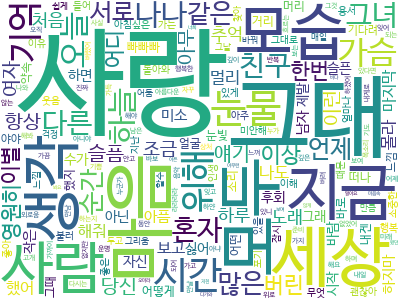

In [41]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

### 당연히 ...
사랑이라는 단어가 가장 많이 나올 것이기 때문에.. Top10 → Top11로 변경

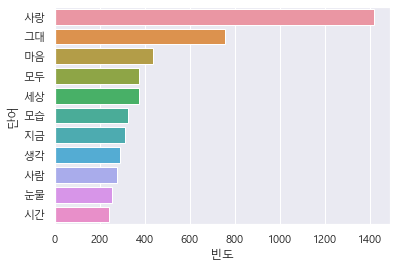

In [78]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

## 연도 칼럼 추가

In [80]:
# 1990 Top11 words
wc11['year'] = '1990y'
wc1990 = wc11
wc1990

,단어,빈도,year
2354,사랑,1417,1990y
366,그대,756,1990y
1446,마음,437,1990y
1673,모두,374,1990y
2508,세상,373,1990y
1694,모습,327,1990y
4095,지금,313,1990y
2440,생각,290,1990y
2351,사람,278,1990y
821,눈물,255,1990y


---

## 2000 년대

In [50]:
# like count 정렬 맞는지 다시 확인
sort_like20.head(2)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
0,418253,보고 싶다,김범수,3rd. 보고 싶다,342238,아무리 기다려도 난 못가 바보처럼 울고 있는 너의 곁에 상처만 주는 나를 왜 ...,https://image.bugsm.co.kr/album/images/200/262...,"['국내', '가요', '노래방', '2000년대', '연대별', 'Y세대', '연...",2000y
1,445413,사랑합니다...,팀,Tim 영민,332812,나빠요 참 그대란 사람 허락도 없이 왜 내 맘 가져요 그대 때문에 난 힘겹게...,https://image.bugsm.co.kr/album/images/200/307...,"['국내', '가요', '노래방', '2000년대', '연대별', 'Y세대', '연...",2000y


In [51]:
lyric20 = sort_like20.Lyric

In [61]:
tagging_okt = []
for i in lyric20:
    tag_word = okt.pos(i)
    tagging_okt.append(tag_word)

In [62]:
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])

In [63]:
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [64]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

(155614, 5000)
5000


In [65]:
cv.get_feature_names()[:10]

['가게', '가겠어', '가겠죠', '가겠지', '가고', '가기', '가까워', '가까이', '가끔', '가나']

In [66]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
2397,사랑,2879
387,그대,1778
2395,사람,708
863,눈물,628
2596,세상,596
58,가슴,538
1432,마음,533
1682,모두,506
522,기억,445
2512,생각,435


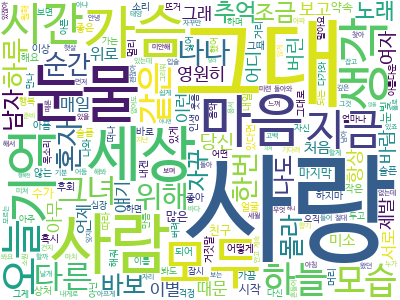

In [67]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

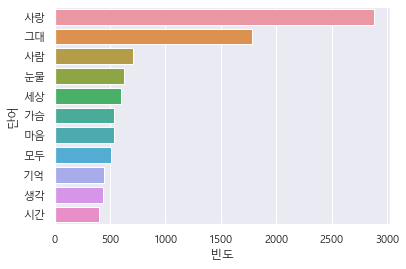

In [68]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [74]:
# 2000 Top11 words
wc11['year'] = '2000y'
wc2000 = wc11
wc2000

,단어,빈도,year
2397,사랑,2879,2000y
387,그대,1778,2000y
2395,사람,708,2000y
863,눈물,628,2000y
2596,세상,596,2000y
58,가슴,538,2000y
1432,마음,533,2000y
1682,모두,506,2000y
522,기억,445,2000y
2512,생각,435,2000y


---

## 2010 년대

In [81]:
# like count 정렬 맞는지 다시 확인
sort_like2010.head(2)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
33,1902268,죽어도 못 보내,2am,죽어도 못 보내,179984,어려도 아픈건 똑같아 세상을 잘 모른다고 아픈걸 모르진 않아 괜찮아 질 거라...,https://image.bugsm.co.kr/album/images/200/215...,"['국내', '가요', '발라드', '100시리즈', '발라드한', '연대별', '...",2010y
44,1898221,외톨이야,씨엔블루(CNBLUE),Bluetory,165137,외톨이야 외톨이야 외톨이야 외톨이야 봐 봐 나를 봐 봐 똑바로 내 두눈을 봐...,https://image.bugsm.co.kr/album/images/200/215...,"['국내', '가요', '아이돌', 'KPOP', '연대별', '2010년대', '...",2010y


In [82]:
lyric2010 = sort_like2010.Lyric

In [83]:
tagging_okt = []
for i in lyric2010:
    tag_word = okt.pos(i)
    tagging_okt.append(tag_word)

In [84]:
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])

In [85]:
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [86]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

(138310, 5000)
5000


In [87]:
cv.get_feature_names()[:10]

['가가', '가게', '가겠지', '가고', '가기', '가까운', '가까워지는', '가까이', '가끔', '가나']

In [88]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
2519,사랑,1437
421,그대,774
2517,사람,552
3437,오늘,521
2598,생각,512
1486,마음,509
2825,시간,446
4128,지금,440
2669,세상,340
1722,모두,301


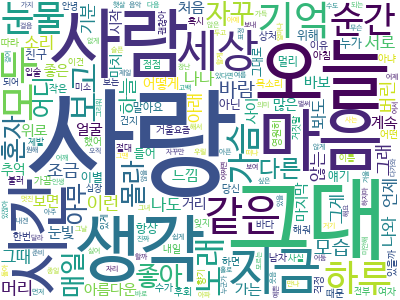

In [89]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

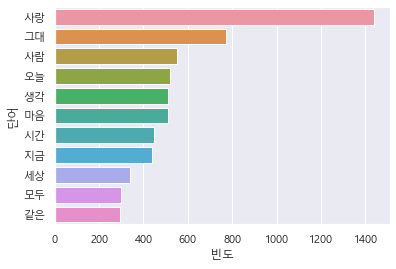

In [90]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [91]:
# 2010 Top11 words
wc11['year'] = '2010y'
wc2010 = wc11
wc2010

,단어,빈도,year
2519,사랑,1437,2010y
421,그대,774,2010y
2517,사람,552,2010y
3437,오늘,521,2010y
2598,생각,512,2010y
1486,마음,509,2010y
2825,시간,446,2010y
4128,지금,440,2010y
2669,세상,340,2010y
1722,모두,301,2010y


---

### 연대별 단어 Top11 append
* 1990년대 11개 + 2000년대 11개 + 2010년대 11개

In [92]:
top11 = wc1990.append(wc2000)
top11 = top11.append(wc2010)
len(top11) 

33

In [97]:
top11.reset_index(drop=True)
display(top11.head(3),top11.tail(3))

,단어,빈도,year
2354,사랑,1417,1990y
366,그대,756,1990y
1446,마음,437,1990y


,단어,빈도,year
2669,세상,340,2010y
1722,모두,301,2010y
174,같은,296,2010y


### to_csv

In [96]:
top11.to_csv('top11.csv',index=False)

---

### 해당 연대의 모든 곡이 아닌, Like Count 기반 Top100 곡만을 선정하여 주요 키워드를 파악한다면?

## 1990년대

In [153]:
len(sort_like90)

572

In [154]:
sort_like90 = sort_like90.head(100)
lyric90 = sort_like90.Lyric

In [155]:
tagging_okt = []
for i in lyric90:
    tag_word = okt.pos(i)
    tagging_okt.append(tag_word)
    
#
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])
            
#
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [156]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

cv.get_feature_names()[:10]

(14265, 2882)
2882


['가게', '가고', '가고있어', '가까운', '가까이', '가끔', '가나', '가난한', '가난했었고', '가눌수']

In [157]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
1357,사랑,344
195,그대,104
464,눈물,72
1438,세상,63
955,모두,62
965,모습,56
267,기억,54
814,마음,50
2373,지금,50
1355,사람,47


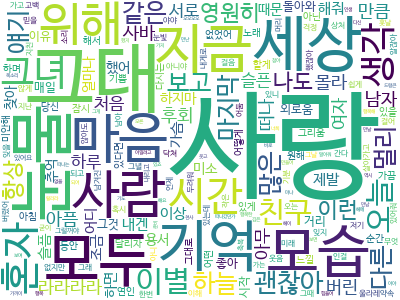

In [158]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

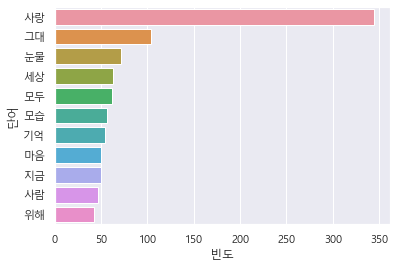

In [159]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [160]:
wc1990_100 = wc11 
wc1990_100

,단어,빈도
1357,사랑,344
195,그대,104
464,눈물,72
1438,세상,63
955,모두,62
965,모습,56
267,기억,54
814,마음,50
2373,지금,50
1355,사람,47


---

## 2000년대

In [166]:
sort_like20 = sort_like20.head(100)
lyric20 = sort_like20.Lyric

In [167]:
tagging_okt = []
for i in lyric20:
    tag_word = okt.pos(i)
    tagging_okt.append(tag_word)
    
#
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])
            
#
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [168]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

cv.get_feature_names()[:10]

(16885, 3425)
3425


['가게', '가고', '가기', '가까이', '가끔', '가나', '가내', '가네', '가네요', '가눌수']

In [169]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
1628,사랑,416
241,그대,189
936,뜨거,102
1626,사람,85
551,눈물,73
38,가슴,64
1112,모두,53
1689,생각,52
967,마음,51
2238,여자,46


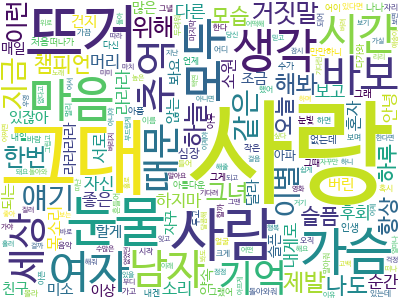

In [170]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

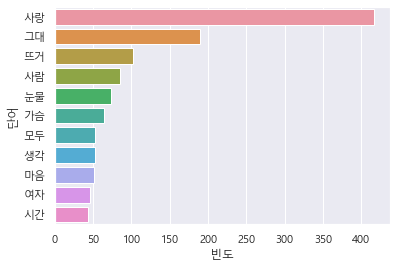

In [171]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [173]:
wc2000_100 = wc11 
wc2000_100

,단어,빈도
1628,사랑,416
241,그대,189
936,뜨거,102
1626,사람,85
551,눈물,73
38,가슴,64
1112,모두,53
1689,생각,52
967,마음,51
2238,여자,46


---

## 2010년대

In [133]:
sort_like2010 = sort_like2010.head(100)

In [134]:
lyric2010 = sort_like2010.Lyric

In [135]:
tagging_okt = []
for i in lyric2010:
    tag_word = okt.pos(i)
    tagging_okt.append(tag_word)
    
#
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])
            
#
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

In [136]:
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

,단어,빈도
1628,사랑,416
241,그대,189
936,뜨거,102
1626,사람,85
551,눈물,73
38,가슴,64
1112,모두,53
1689,생각,52
967,마음,51
2238,여자,46


In [137]:
cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

cv.get_feature_names()[:10]

(16579, 3385)
3385


['가겠다', '가겠지', '가고', '가까워진다면', '가까워질수록', '가까이', '가끔', '가나', '가난하고', '가네']

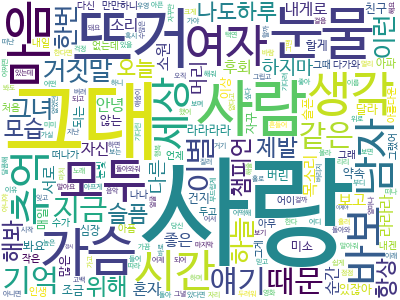

In [140]:
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

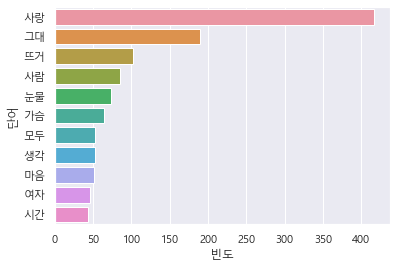

In [141]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

In [142]:
wc2010_100 = wc11 
wc2010_100

,단어,빈도
1628,사랑,416
241,그대,189
936,뜨거,102
1626,사람,85
551,눈물,73
38,가슴,64
1112,모두,53
1689,생각,52
967,마음,51
2238,여자,46


In [174]:
# Top11 words
wc1990_100['year'] = '1990y'
wc2000_100['year'] = '2000y'
wc2010_100['year'] = '2010y'


In [175]:
top11_like100 = wc1990_100.append(wc2000_100)
top11_like100 = top11_like100.append(wc2010_100)
len(top11_like100)

33

In [176]:
top11_like100.to_csv('top11_like100.csv',index=False)

### 전체 코드

In [ ]:
# like count 정렬 맞는지 다시 확인
sort_like90.head(2)

#
lyric90 = sort_like90.Lyric

#

tagging_okt = []
for i in lyric90:
    tag_word = okt.pos(i)
    tagging_okt.append(tag_word)
    
#
corpus = []
for song in tagging_okt:
    for word in song:
        if (word[1] == 'Adjective') or (word[1] =='Noun') or (word[1] =='Verb'):
            corpus.append(word[0])
            
#
word_dict = {}
for i in corpus:
    if i in word_dict:
        word_dict[i] += 1
    else: 
        word_dict[i] = 1
        
# print(word_dict)

#

cv = CountVectorizer(max_features=5000, stop_words=stop_w) 
tdm = cv.fit_transform(corpus)

# tdm.shape
# len(cv.get_feature_names())
print(tdm.shape)
print(len(cv.get_feature_names()))

cv.get_feature_names()[:10]

#
wc = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat
})

wc.sort_values('빈도', ascending=False).head(30)

#
WC = WordCloud(font_path='NanumBarunGothic.ttf' ,background_color='white', width=400, height=300)
count_dic = wc.set_index('단어')['빈도'].to_dict()
# count_dic
cloud = WC.generate_from_frequencies(count_dic)
cloud.to_image()

# 
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
plt.rc('font', family='malgun gothic') # 그래프에서 한글 깨지는 현상 방지
plt.rcParams['axes.unicode_minus']=False #음수 부호 깨짐 방지
wc11 = wc.sort_values('빈도', ascending=False).head(11)
sns.barplot(wc11['빈도'],wc11['단어'])

sns.set(rc={'figure.figsize':(20,20)}) # , font='NanumBarunGothic.ttf'

#
# 1990 Top11 words
wc11['year'] = '1990y'
wc11
